## Reading ICESat-2 Data in for Analysis
### Example notebook to showcase ICESat-2 data read-in using icepyx
This notebook illustrates the use of icepyx for reading ICESat-2 data files, loading them into a data object.
Currently the default data object is an Xarray Dataset, with ongoing work to provide support for other data object types.

For more information on how to order and download ICESat-2 data, see the [icepyx data access tutorial](https://github.com/icesat2py/icepyx/blob/main/doc/examples/ICESat-2_DAAC_DataAccess_Example.ipynb).

### Motivation
Most often, when you open a data file, you must specify the underlying data structure and how you'd like the information to be read in.
A simple example of this, for instance when opening a csv or similarly delimited file, is letting the software know if the data contains a header row, what the data type is (string, double, float, boolean, etc.) for each column, what the delimeter is, and which columns or rows you'd like to be loaded.
Many ICESat-2 data readers are quite manual in nature, requiring that you accurately type out a list of string paths to the various data variables.

icepyx simplifies this process by relying on its awareness of ICESat-2 specific data file variable storage structure.
Instead of needing to manually iterate through the beam pairs, you can provide a few options to the `Read` object and icepyx will do the heavy lifting for you (as detailed in this notebook).

### Approach
If you're interested in what's happening under the hood: icepyx turns your instructions into something called a catalog, then uses the Intake library and the catalog to actually load the data into memory. Specifically, icepyx creates an [Intake](https://intake.readthedocs.io/en/latest/) data [catalog](https://intake.readthedocs.io/en/latest/catalog.html) for each requested variable and then merges the read-in data from each of the variables to create a single data object.

Intake catalogs are powerful (and the tool we selected) because they can be saved, shared, modified, and reused to reproducibly read in a set of data files in a consistent way as part of an analysis workflow.
This approach streamlines the transition between data sources (local/downloaded files or, ultimately, cloud/bucket access) and data object types (e.g. [Xarray Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) or [GeoPandas GeoDataFrame](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html)).

#### Credits
* original notebook by: Jessica Scheick
* notebook contributors: 
* templates for default ICESat-2 Intake catalogs from: [Wei Ji]() and [Tian]().


### Import packages, including icepyx

In [ ]:
%load_ext autoreload
import icepyx as ipx
%autoreload 2

### Quick Start Guide
For those who might be looking into playing with this (but don't want to navigate the still messy notebook)

In [ ]:
path = '/Users/jessica/computing/icepyx/test_data/'
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
reader = ipx.Read(path, "ATL06", pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the defualt pattern

In [ ]:
reader.vars.append(beam_list=['gt1l', 'gt3r'], var_list=['h_li', "latitude", "longitude"])

In [7]:
ds = reader.load()
ds

<xarray.Dataset>
Dimensions:              (delta_time: 55654, gran_idx: 3, spot: 2)
Coordinates:
  * delta_time           (delta_time) datetime64[ns] 2019-02-22T01:06:07.5054...
  * gran_idx             (gran_idx) <U6 '084902' '090202' '091002'
  * spot                 (spot) int64 2 5
    source_file          (gran_idx) <U91 '/Users/jessica/computing/icepyx/tes...
    gt                   (gran_idx, spot) object 'gt3r' 'gt1l' ... 'gt3r' 'gt1l'
Data variables:
    sc_orient            (gran_idx) int8 0 0 0
    cycle_number         (gran_idx) int8 2 2 2
    rgt                  (gran_idx) int16 849 902 910
    h_li                 (spot, gran_idx, delta_time) float32 nan nan ... nan
    latitude             (spot, gran_idx, delta_time) float64 nan nan ... nan
    longitude            (spot, gran_idx, delta_time) float64 nan nan ... nan
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18 ... 20...
    data_start_utc       (gran_idx) |S27 b'2019-02-22T01:03:44.199777Z' ... b...
    data_end_utc         (gran_idx) |S27 b'2019-02-22T01:07:38.112327Z' ... b...
Attributes:
    data_product:  ATL06
    Description:   The land_ice_height group contains the primary set of deri...
    data_rate:     Data within this group are sparse.  Data values are provid...

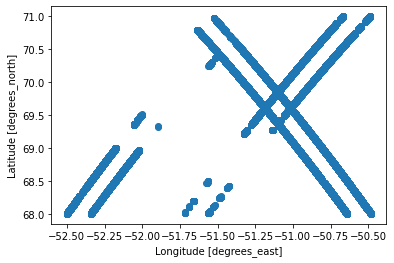

In [8]:
ds.plot.scatter(x="longitude", y="latitude")

In [ ]:
import os
import fnmatch
import glob
import pathlib
import fsspec
from fsspec.implementations.local import LocalFileSystem

https://github.com/OSOceanAcoustics/echopype/blob/ab5128fb8580f135d875580f0469e5fba3193b84/echopype/utils/io.py
https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_map#fsspec.spec.AbstractFileSystem.glob
https://filesystem-spec.readthedocs.io/en/latest/_modules/fsspec/implementations/local.html
https://github.com/OSOceanAcoustics/echopype/blob/ab5128fb8580f135d875580f0469e5fba3193b84/echopype/convert/api.py#L380
https://echopype.readthedocs.io/en/stable/convert.html


### Key steps for loading (reading) ICESat-2 data

Reading in ICESat-2 data with icepyx happens in a few simple steps:
1. Let icepyx know where to find your data (this might be local files or urls to data in cloud storage)
2. Tell icepyx how to interpret the filename format
3. Create an icepyx `Read` object
4. Make a list of the variables you want to read in
5. Load your data into memory (or read it in lazily, if you're using Dask)

We go through each of these steps in more detail in this notebook.

### Step 0: Get some data if you haven't already
Here are a few lines of code to get you set up with a few data files if you don't already have some on your local system.

In [ ]:
region_a = ipx.Query('ATL06',[-55, 68, -48, 71],['2019-02-22','2019-02-28'], \
                           start_time='00:00:00', end_time='23:59:59')

In [ ]:
region_a.earthdata_login('jessica.scheick','jbscheick@gmail.com')

In [ ]:
region_a.download_granules(path=path)

In [ ]:
lfs = LocalFileSystem()

In [ ]:
lfs

In [ ]:
lfs.ls("/")

In [ ]:
fsmap = fsspec.get_mapper(str(path))
output_fs = fsmap.fs

In [ ]:
output_fs.ls()

In [ ]:
output_fs

In [ ]:
source_file, file_format


if not isinstance(save_path, Path) and not isinstance(save_path, str):
            raise TypeError("save_path must be a string or Path")

        fsmap = fsspec.get_mapper(str(save_path), **output_storage_options)
        output_fs = fsmap.fs

        # Use the full path such as s3://... if it's not local, otherwise use root
        if isinstance(output_fs, LocalFileSystem):
            root = fsmap.root
        else:
            root = save_path
        if Path(root).suffix == "":  # directory
            out_dir = root
            out_path = os.path.join(root, Path(source_file).stem + file_format)
        else:  # file
            out_dir = os.path.dirname(root)
            out_path = os.path.join(out_dir, Path(root).stem + file_format)

### Step 1: Set data source path

Provide a full path to the data to be read in (i.e. opened).
Currently accepted inputs are:
* a directory
* a single file

All files to be read in *must* have a consistent filename pattern.
If a directory is supplied as the data source, all files in any subdirectories that match the filename pattern will be included.

S3 bucket data access is currently under development, and requires you are registered with NSIDC as a beta tester for cloud-based ICESat-2 data.
icepyx is working to ensure a smooth transition to working with remote files.
We'd love your help exploring and testing these features as they become available!

In [ ]:
urlpath = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL03/004/2019/11/30/ATL03_20191130221008_09930503_004_01.h5'

In [ ]:
filepath = '/Users/jessica/computing/icepyx/test_data/ATL06-20181214041627-Sample.h5'

In [ ]:
path = '/Users/jessica/computing/icepyx/test_data/'

In [ ]:
filepath2 = '/Users/jessica/computing/icepyx/test_data/test_subdir/ATL03_20191130221008_09930503_004_01.h5'

### Step 2: Create a filename pattern for your data files

Files provided by NSIDC match the format `"ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"` where the parameters in curly brackets indicate a parameter name (left of the colin) and character length or format (right of the colin).
Some of this information is used during data opening to help correctly read and label the data within the data structure, particularly when multiple files are opened simultaneously.

By default, icepyx will assume your filenames follow the default format.
However, you can easily read in other ICESat-2 data files by supplying your own filename pattern.
For instance, `pattern="ATL{product:2}-{datetime:%Y%m%d%H%M%S}-Sample.h5"`.

In [ ]:
pattern = 'ATL06-{datetime:%Y%m%d%H%M%S}-Sample.h5'
# pattern = 'ATL{product:2}-{datetime:%Y%m%d%H%M%S}-Sample.h5'

In [ ]:
pattern = "ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"

In [ ]:
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"

### Step 3: Create an icepyx read object

The `Read` object has two required inputs:
- `path` = a string with the full file path or full directory path to your hdf5 (.h5) format files.
- `product` = the data product you're working with, also known as the "short name".

The `Read` object also accepts two optional keyword inputs:
- `pattern` = a formatted string indicating the filename pattern required for Intake's path_as_pattern argument.
- `catalog` = a string with the full path to an Intake catalog, for users who wish to use their own catalog (note this may have unintended consequenses if multiple granules are being combined).

In [ ]:
reader = ipx.Read(path, "ATL06", pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the defualt pattern

In [12]:
#reader = ipx.Read(path, "ATL06", pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the defualt pattern06", pattern) # or ipx.Read(filepath, "ATLXX") if your filenames match the defualt patternDEL
reader._filelist

['/Users/jessica/computing/icepyx/test_data/processed_ATL06_20190225121032_09020203_004_01.h5',
 '/Users/jessica/computing/icepyx/test_data/processed_ATL06_20190226005526_09100205_004_01.h5',
 '/Users/jessica/computing/icepyx/test_data/processed_ATL06_20190222010344_08490205_004_01.h5']

### Step 4: Specify variables to be read in

To load your data into memory or prepare it for analysis, icepyx needs is which variables you'd like to read in.
If you've used icepyx to download data from NSIDC with variable subsetting (which is the default), then you may already be familiar with the icepyx `Variables` module and how to create and modify lists of variables.
We showcase a specific case here, but we encourage you to check out [the icepyx Variables example](https://github.com/icesat2py/icepyx/blob/main/doc/examples/Working_with_ICESat-2_Data_Variables.ipynb) for a thorough trip through how to create and manipulate lists of ICESat-2 variable paths (examples are provided for multiple data products).

You can use a default list that loads commonly used variables for your data product, or create your own list of variables to be read in.
icepyx will determine what variables are available for you to read in by creating a list from one of your source files.
If you have multiple files that you're reading in, icepyx will automatically generate a list of filenames and take the first one to get the list of available variables.

Thus, if you have different variables available across files (even from the same data product), you may run into issues and need to come up with a workaround (we can help you do so!).
We anticipate most users will have the minimum set of variables they are seeking to load available across all data files, so we're not currently developing this feature.
Please get in touch if it would be a helpful feature for you or if you encounter this problem!

For a basic case, let's say we want to read in height, latitude, and longitude for all beam pairs.
We create our variables list as

In [ ]:
# reader.vars.append(var_list=['h_li', "latitude", "longitude"])
reader.vars.append(beam_list=['gt1l', 'gt3r'], var_list=['h_li', "latitude", "longitude"])

Then we can view a dictionary of the variables we'd like to read in.

In [9]:
reader.vars.wanted

{'sc_orient': ['orbit_info/sc_orient'],
 'atlas_sdp_gps_epoch': ['ancillary_data/atlas_sdp_gps_epoch'],
 'cycle_number': ['orbit_info/cycle_number'],
 'rgt': ['orbit_info/rgt'],
 'data_start_utc': ['ancillary_data/data_start_utc'],
 'data_end_utc': ['ancillary_data/data_end_utc'],
 'h_li': ['gt1l/land_ice_segments/h_li', 'gt3r/land_ice_segments/h_li'],
 'latitude': ['gt1l/land_ice_segments/latitude',
  'gt3r/land_ice_segments/latitude'],
 'longitude': ['gt1l/land_ice_segments/longitude',
  'gt3r/land_ice_segments/longitude']}

Don't forget - if you need to start over generating your wanted variables list, it's easy!

In [ ]:
reader.vars.remove(all=True)

In [10]:
groups_list = ipx.core.variables.list_of_dict_vals(reader.vars.wanted)

In [ ]:
wanted_dict, wanted_groups = ipx.core.variables.Variables.parse_var_list(groups_list, tiered=False)
wanted_groups_set = set(wanted_groups)
# returns the wanted groups as a list of lists with group path string elements separated
vgrp, wanted_groups_tiered = ipx.core.variables.Variables.parse_var_list(groups_list, tiered=True)
wanted_vars = list(vgrp.keys())

In [ ]:
print(wanted_dict)
print(wanted_groups)
print(vgrp)
print(wanted_vars)
print(wanted_groups_tiered)

In [ ]:
[print(k) for k,v in wanted_dict.items() if any('gt3r/land_ice_segments' in x for x in v)]

In [ ]:
wanted_vars[i] for i, x in enumerate(wanted_dict) if grp_path in x

['orbit_info/sc_orient', 'ancillary_data/atlas_sdp_gps_epoch', 'orbit_info/cycle_number', 'orbit_info/rgt', 'ancillary_data/data_start_utc', 'ancillary_data/data_end_utc', 'gt1l/land_ice_segments/h_li', 'gt3r/land_ice_segments/h_li', 'gt1l/land_ice_segments/latitude', 'gt3r/land_ice_segments/latitude', 'gt1l/land_ice_segments/longitude', 'gt3r/land_ice_segments/longitude']


In [ ]:
reader.vars.avail()

### Step 5: Loading your data

Now that you've set up all the options, you're ready to read your ICESat-2 data into memory!

In [18]:
ds = reader.load()

In [19]:
ds

<xarray.Dataset>
Dimensions:              (delta_time: 55654, gran_idx: 3, spot: 2)
Coordinates:
  * delta_time           (delta_time) datetime64[ns] 2019-02-22T01:06:07.5054...
  * gran_idx             (gran_idx) object '084902' '090202' '091002'
  * spot                 (spot) int64 2 5
    source_file          (gran_idx) <U91 '/Users/jessica/computing/icepyx/tes...
    gt                   (gran_idx, spot) object 'gt3r' 'gt1l' ... 'gt3r' 'gt1l'
Data variables:
    sc_orient            (gran_idx) int8 0 0 0
    cycle_number         (gran_idx) int8 2 2 2
    rgt                  (gran_idx) int16 849 902 910
    h_li                 (spot, gran_idx, delta_time) float32 nan nan ... nan
    latitude             (spot, gran_idx, delta_time) float64 nan nan ... nan
    longitude            (spot, gran_idx, delta_time) float64 nan nan ... nan
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18 ... 20...
    data_start_utc       (gran_idx) |S27 b'2019-02-22T01:03:44.199777Z' ... b...
    data_end_utc         (gran_idx) |S27 b'2019-02-22T01:07:38.112327Z' ... b...
Attributes:
    data_product:  ATL06
    Description:   The land_ice_height group contains the primary set of deri...
    data_rate:     Data within this group are sparse.  Data values are provid...

### On to data analysis!

From here, you can begin your analysis.
Ultimately, icepyx aims to include an Xarray extension with ICESat-2 aware functions that allow you to do things like easily use only data from strong beams.
That functionality is still in development.
For fun, we've included a basic plot made with Xarray's built in functionality.

In [ ]:
ds.plot.scatter(x="longitude", y="latitude")

In [ ]:
# next step (but another PR): xarray extension with icesat-2 aware functions (like "get_strong_beams", etc.)

In [ ]:
import h5py

In [ ]:
with h5py.File(filepath, "r") as fi:
            try:

                # Read in varibales of interest (more can be added!)
                dac = fi[group[k] + "/land_ice_segments/geophysical/dac"][:]
                lat = fi[group[k] + "/land_ice_segments/latitude"][:]
                lon = fi[group[k] + "/land_ice_segments/longitude"][:]
            except:
                pass

In [ ]:
fi = h5py.File(filepath, "r")

In [ ]:
print(fi["gt1l"].attrs.keys())
print(fi["gt1l"].attrs["atlas_spot_number"])
print(fi["gt1l"].attrs["sc_orientation"])

In [ ]:
grp = fi["ancillary_data"]

In [ ]:
def add_item(item):
    print(item)
    return item
    
for var in grp.visit(add_item):
    print(grp.visititems(var))

### More on Intake catalogs and the read object

As anyone familiar with ICESat-2 hdf5 files knows, one of the challenges to reading in data is looping through all of the beam pairs for each track.
The icepyx read module takes advantage of icepyx's variables module, which has some awareness of ICESat-2 data and uses that to save the user the trouble of having to loop through each beam pair.
The `reader.load()` function does this by automatically creating minimal Intake catalogs for each variable path, reading in the data, and merging each variable into a ready-to-analyze Xarray DataSet.
The Intake savvy user may wish to view the template catalog or use an existing catalog.

#### Viewing the template catalog

You can access the ICESat-2 catalog template as an attribute of the read object.

***NOTE: accessing `reader.is2catalog` creates a template with a placeholder in the 'group' parameter; thus, it will not work to actually read in data***

In [ ]:
reader.is2catalog

In [ ]:
reader.is2catalog.gui

#### Use an existing catalog
If you already have a catalog for your data, you can supply that when you create the read object.

In [ ]:
catpath = '/Users/jessica/computing/icepyx/test_data/test_catalog.yml'
reader = ipx.Read(filepath, pattern, catpath)

Then, you can use the catalog you supplied by calling intake's `read` directly to read in the specified data variable.

In [ ]:
ds = reader.is2catalog.read()

***NOTE: this means that you will only be able to read in a single data variable!***

To take advantage of icepyx's knowledge of ICESat-2 data nesting of beam pairs and read in multiple related variables at once, you must use the variable approach outlined earlier in this tutorial.

In [ ]:
ds = reader.load()
ds

#### More customization options

If you'd like to use the icepyx ICESat-2 Catalog template to create your own customized catalog, we recommend that you access the `build_catalog` function directly, which returns an Intake Catalog instance.

This function accepts as keyword input arguments (kwargs) dictionaries with appropriate keys (depending on the Intake driver you are using).
The simplest version of this is specifying the variable parameters and paths of interest.
`var_paths` may contain "variables", each of which must then be further defined by `var_path_params`.
You cannot use glob-like path syntax to access variables (so `var_path = '/*/land_ice_segments'` is NOT VALID).

In [ ]:
import icepyx.core.is2cat as is2cat

# build a custom ICESat-2 catalog with a group and parameter
cat = is2cat.build_catalog(var_paths = "/{{gt}}/land_ice_segments",
                     var_path_params = [{"name": "gt",
                                         "description": "Ground track",
                                         "type": "str",
                                         "default": "gt1l",
                                         "allowed": ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
                                        }]
                    )

#### Saving your catalog
If you create a highly customized ICESat-2 catalog, you can use Intake's `save` to export it as a .yml file.

Don't forget you can easily use an existing catalog (such as this highly customized one you just made) to read in your data with `reader = ipx.Read(filepath, pattern, catalog)` (so it's as easy as re-creating your reader object with your modified catalog).

In [ ]:
catpath = '/Users/jessica/computing/icepyx/test_data/test_catalog.yml'
cat.save(catpath)

In [ ]:
# DEL
readcatalog = intake.open_catalog(catpath)